In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
from numpy import sin, cos, tan, pi
from control import TransferFunction as TF

In [2]:
import txt_mixin

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
import py_block_diagram

In [5]:
import importlib

In [6]:
import sys

In [7]:
sys.path

['',
 '/home/pi/sabbatical_github/cart_pendulum/arduino_only',
 '/home/pi/git/py_block_diagram',
 '/home/pi/git/research',
 '/home/pi/git/krauss_misc',
 '/home/pi/git/report_generation',
 '/home/pi/git/teaching',
 '/home/pi/git/bad',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/home/pi/.local/lib/python3.7/site-packages',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/pi/.ipython']

In [8]:
importlib.reload(py_block_diagram)

<module 'py_block_diagram' from '/home/pi/git/py_block_diagram/py_block_diagram/__init__.py'>

In [9]:
import py_block_diagram as pybd

### Helper Function

- draw the block diagram as needed to verify things

In [10]:
def mydraw(block_list,xlim=None,ylim=None):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    mysys = pybd.block_diagram(block_list,ax)
    mysys.draw()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    mysys.axis_off()
    return mysys

## System Description

In [11]:
block_list = []

In [12]:
U = pybd.int_constant_block(3500,"U_cl")

In [13]:
U.width = 4

In [14]:
U.place_absolute(0,0)

In [15]:
block_list.append(U)

In [16]:
sum1 = pybd.summing_junction()

In [17]:
sum1.place_relative(U,"right")

In [18]:
sum1.set_input1(U)

In [19]:
block_list.append(sum1)

In [20]:
D = pybd.PD_controller(0.1,0.01)

In [21]:
D.place_relative(sum1,"right")

In [22]:
D.set_input_block(sum1)

In [23]:
D.Kd

0.01

In [24]:
D.Kp

0.1

In [25]:
block_list.append(D)

In [26]:
diff_motors = pybd.custom_actuator("dual_motors","two_motors_dbl_actuator","&motors")

In [27]:
line_sense = pybd.custom_sensor("line_sense","qtr_line_sensor","&qtr")

In [28]:
pend_enc = pybd.custom_sensor("pend_enc","pendulum_encoder","")

In [29]:
G = pybd.plant_with_double_actuator_two_sensors(pend_enc,\
                                                line_sense,\
                                                diff_motors,"Robot")

In [30]:
sat = pybd.sat2_adjustable_block(150)

In [31]:
sat.set_input_block(D)

In [32]:
block_list.append(sat)

In [33]:
sat.place_relative(D, "right")

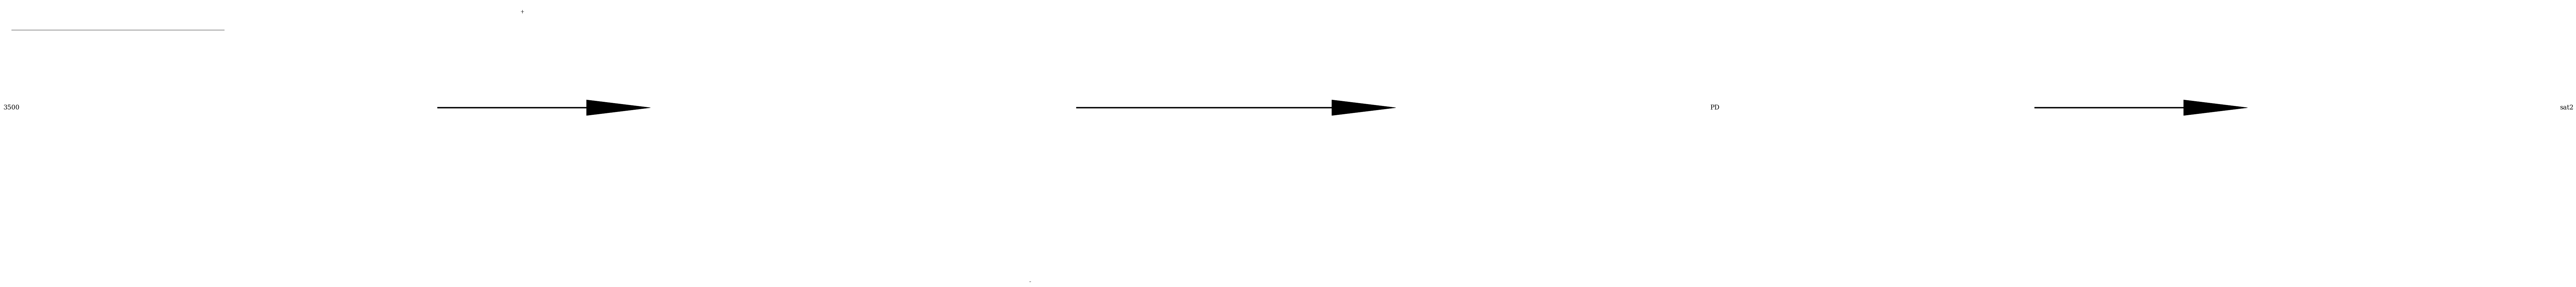

In [34]:
mydraw(block_list)

In [35]:
add1 = pybd.addition_block()

In [36]:
subtract1 = pybd.subtraction_block()

In [37]:
v_nom = pybd.int_constant_block(200,'v_nom_block')

In [38]:
v_nom.place_relative(sat, "right", yshift=4, xshift=-4)

In [39]:
block_list.append(v_nom)

In [40]:
add1.place_relative(sat, "right", yshift=1, xshift=3)

In [41]:
subtract1.place_relative(sat, "right", yshift=-2)

In [42]:
block_list.append(add1)

In [43]:
block_list.append(subtract1)

In [44]:
add1.set_inputs(v_nom, sat)

In [45]:
subtract1.set_inputs(v_nom, sat)

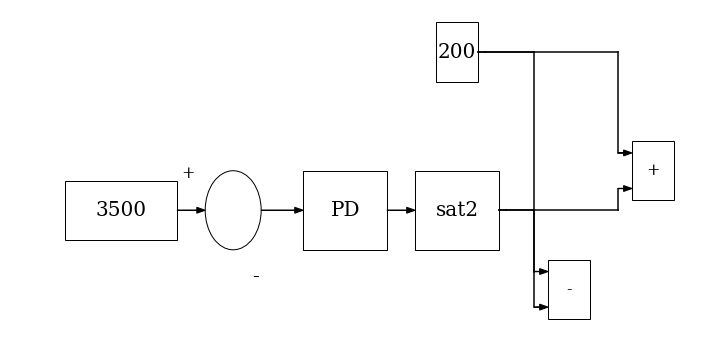

In [46]:
mydraw(block_list)

In [47]:
satP = pybd.sat2_adjustable_block(400,label="satP",variable_name="satP")

In [48]:
satP.place_relative(add1,"right")

In [49]:
block_list.append(satP)

In [50]:
satP.set_input_block(add1)

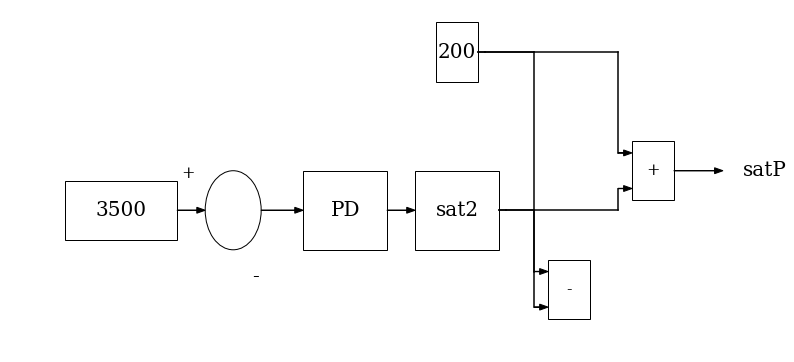

In [51]:
mydraw(block_list)

In [52]:
satN = pybd.sat2_adjustable_block(400,label="satN",variable_name="satN")

In [53]:
satN.place_relative(subtract1,"right")

In [54]:
block_list.append(satN)

In [55]:
satN.set_input_block(subtract1)

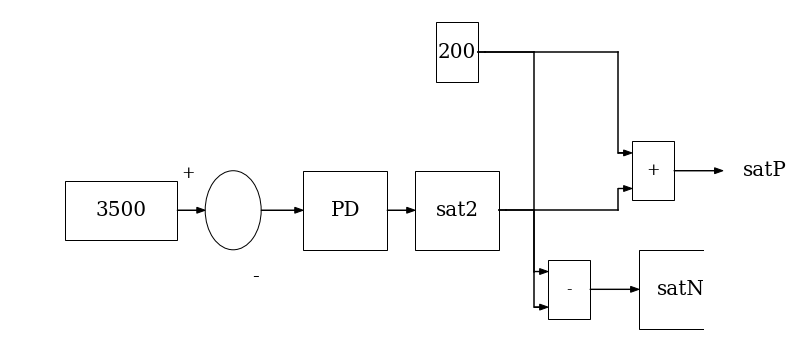

In [56]:
mydraw(block_list)

In [57]:
G.set_inputs(satP,satN)

In [58]:
G.place_relative(sat,"right",16)

In [59]:
block_list.append(G)

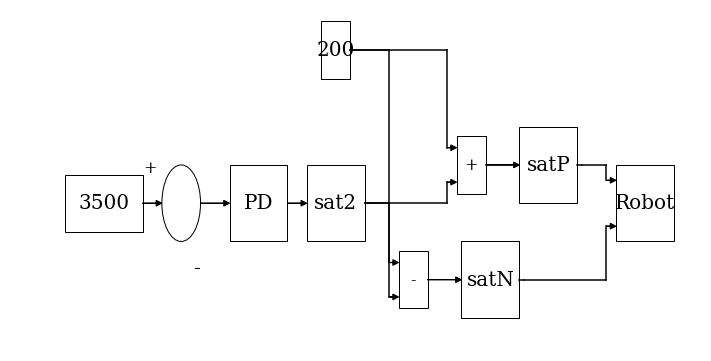

In [60]:
mydraw(block_list)

In [61]:
Y = pybd.output_block("line position",G.sensor2)

In [62]:
Y.place_relative(G.sensor2, "right",8)

In [63]:
Y.width = 6

In [64]:
Y2 = pybd.output_block("pend. encoder", G.sensor1)

In [65]:
Y2.place_relative(G.sensor1, "right", 8)

In [66]:
block_list.append(Y2)

In [67]:
sum1.set_input2(G.sensor2)

In [68]:
block_list.append(Y)

In [69]:
sum1.fb_vertical_offset = -5

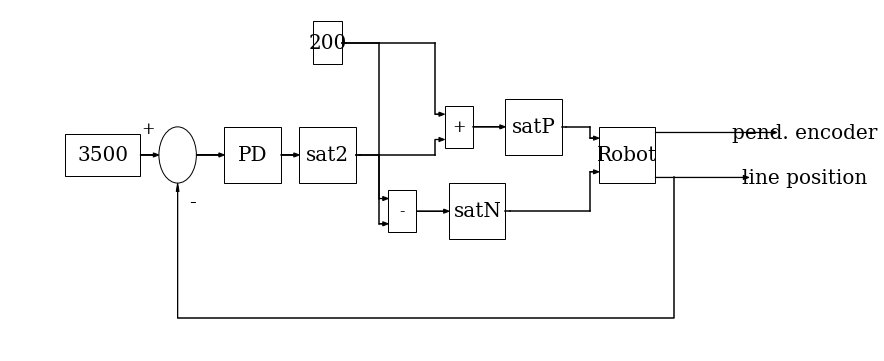

In [70]:
mysys = mydraw(block_list)

In [71]:
G.x

28

In [72]:
G.y

0

In [73]:
Y.input_block.x

29.5

In [74]:
Y.input_block.y

-0.8

In [75]:
Y.input_block.width

0

In [76]:
Y.input_block.height

0

In [77]:
Y.wire_style

'h'

In [78]:
mysys.append_menu_param_from_block(D,"Kp")

In [79]:
mysys.append_menu_param_from_block(D,"Kd")

In [80]:
mysys.append_menu_param_from_block(v_nom,"value",1)

In [81]:
mysys.append_menu_param_global_variable("t_stop")

In [82]:
mysys.menu_param_list

[('PD_block.Kp', 0),
 ('PD_block.Kd', 0),
 ('v_nom_block.value', 1),
 ('t_stop', 0)]

## Print Blocks

In [83]:
mysys.print_blocks = [sum1,D,sat,add1,subtract1,satP,satN,pend_enc,line_sense]

## Execution Order

In [84]:
mysys.find_execution_order([U,sum1,D,sat,v_nom,add1,subtract1])

In [85]:
mysys.execution_order

## Codegen Test

In [86]:
msg = "Cart Pendulum Line Follow 3"

In [87]:
mysys.welcome_msg = msg

In [88]:
ls *.ino

cart_pendulum_template1_vib_only.ino  cart_pendulum_template2.ino


In [89]:
template_fn = "cart_pendulum_template2.ino"

In [90]:
mysys.generate_arduino_code("cart_pendulum_autogen_3_line_follow_with_two_sensors_no_vib", template_fn,\
                           verbosity=1)

block: <py_block_diagram.int_constant_block object at 0xad4b8b10>
block: <py_block_diagram.summing_junction object at 0xad4b8a70>
block: <py_block_diagram.PD_controller object at 0xad4cd7f0>
block: <py_block_diagram.sat2_adjustable_block object at 0xad4ab190>
block: <py_block_diagram.int_constant_block object at 0xad5041b0>
block: <py_block_diagram.addition_block object at 0xad504af0>
block: <py_block_diagram.subtraction_block object at 0xad5041f0>
block: <py_block_diagram.sat2_adjustable_block object at 0xab6cd0f0>
block: <py_block_diagram.sat2_adjustable_block object at 0xad4404b0>
block: <py_block_diagram.plant_with_double_actuator_two_sensors object at 0xad510870>
block: <py_block_diagram.output_block object at 0xaae217f0>
block: <py_block_diagram.output_block object at 0xaae16650>


bdsysinitcode
int_constant_block U_cl = int_constant_block(3500);
summing_junction sum1_block = summing_junction();
PD_control_block PD_block = PD_control_block(0.1, 0.01);
sat2_adjustable_block sat2_b

In [91]:
add1._get_arduino_param_str()

''